In [1]:
import numpy as np
import pandas as pd
from control import lqr
import scipy
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from tqdm import tqdm
from single_photons.estimators.kalman import KalmanFilter
import single_photons.utils.constants as ct
from single_photons.environment import Cavity_Particle

In [2]:
T = 293
p = 1e-6
R = 147e-9
rho = 2200
index_refraction = 1.4440
tweezer_wavelength = 1.55e-6
tweezer_power = 200e-3
tweezer_waist = 0.6e-6
cavity_waist = 100e-6
cavity_length = 50e-3
eta_detec = 0.178

In [3]:
m_p = 4 / 3 * np.pi * R**3 * rho
v_gas = np.sqrt(3 * ct.kb * T / ct.m_gas)
Nm = rho/(ct.amu*60.08) #SiO2 molecular density
tweezer_freq = 2 * np.pi * ct.c / tweezer_wavelength
pol_permit_ratio = 3/Nm*(index_refraction**-1)/(index_refraction**2+2) #from C-M
gamma = 15.8 * R**2 * p / (m_p * v_gas)
omega = (
    np.sqrt(12 / np.pi)
    * np.sqrt((index_refraction**2 - 1) / (index_refraction**2 + 2)) ** 3
    * np.sqrt(tweezer_power)
    / (tweezer_waist**2 * np.sqrt(rho * ct.c))
)
coupling = 9*pol_permit_ratio**2*tweezer_power*tweezer_freq**5/\
    (128*np.pi**2*ct.c**6*m_p*omega)
#coupling = coupling/(ct.hbar/(2*m_p*omega))
coupling = 6.68e-42

detuning = 1 * omega
cavity_linewidth = omega
cavity_freq = detuning + tweezer_freq

g_cs = (
    np.power(12 / np.pi, 1 / 4)
    * np.power((index_refraction**2 - 1) / (index_refraction**2 + 2), 3 / 4)
    * np.power(tweezer_power * R**6 * cavity_freq**6 / (ct.c**5 * rho), 1 / 4)
    / (np.sqrt(cavity_length) * cavity_waist)
)

g_cs = 0

period = 2 * np.pi / omega
delta_t = 1e-9
control_step = 30 # defined as int, number of time steps of simulation necessary to compute the control policy
t = np.arange(0, 50 * period, delta_t)
N = t.shape[0]

In [4]:
env = Cavity_Particle(
    omega,
    gamma,
    detuning,
    cavity_linewidth,
    g_cs,
    coupling,
    radius=R,
    rho=rho,
    eta_detection=eta_detec,
    T=T
)

In [5]:
pulse_amplitude = 0
pulse_center = 2500
pulse_width = 200
alpha_in = []
for i in range(t.shape[0]):
    # alpha = i*(t.shape[0]-i)*pulse_amplitude
    alpha = pulse_amplitude * (
        np.exp(-((i - pulse_center) ** 2) / (2 * pulse_width**2))
    )
    # +np.exp(-(i-(pulse_center+t.shape[0]/2))**2/(2*pulse_width**2)))
    alpha_in.append(alpha)

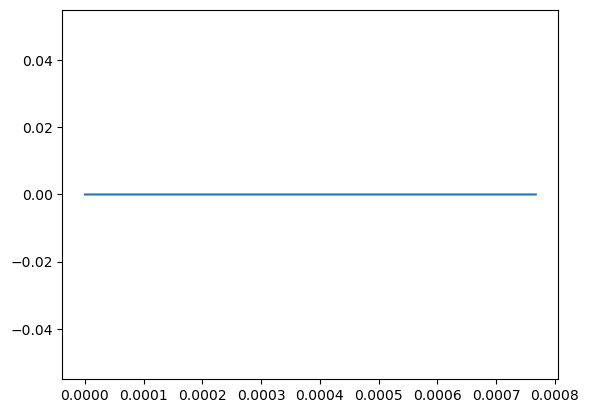

In [6]:
plt.plot(t, alpha_in)
plt.show()

In [7]:
variance_process = 4 * ct.kb * env.T * env.__gamma__ * env._m_ / (env.zp_p**2)
variance_process = variance_process + np.power(env.backaction / env.zp_p, 2)
std_detection = 1.3

In [8]:
Q = np.array(
    [
        [(env.__optical_noise__**2)*cavity_linewidth, 0, 0, 0],
        [0, (env.__optical_noise__**2)*cavity_linewidth, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, variance_process],
    ]
)
R = np.array([[np.power(std_detection, 2)]])

In [11]:
Ad = scipy.linalg.expm(env.A *control_step*delta_t)
cost_states = np.array([[1e-5, 0, 0, 0],
                        [0, 1e-5, 0, 0],
                        [0, 0, omega/1e5, 0],
                        [0, 0, 0, omega/1e3]
                       ])
(G, S, E) = lqr(Ad, env.B*delta_t*control_step, cost_states, omega)

x0 = 10
P0 = 1*np.matrix(np.eye(4))
estimation = np.matrix([[0], [0], [x0], [0]])
states = np.array([[0], [0], [x0], [0.0]])
G, omega, Ad, env.B*delta_t*control_step

(array([[1.16568088e-01, 9.25993497e-04, 2.09284140e+06, 4.11558473e+06]]),
 409282.306543384,
 array([[ 0.99380465,  0.01220301,  0.        ,  0.        ],
        [-0.01220301,  0.99380465,  0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.99992462,  0.01227816],
        [ 0.        ,  0.        , -0.01227816,  0.99992462]]),
 array([[0.e+00],
        [0.e+00],
        [0.e+00],
        [3.e-08]]))

In [17]:
new_states = np.zeros((N, 4))
measured_states = np.zeros((N))
estimated_states = np.zeros((N, 4))
estimated_states[0, :] = estimation.reshape((4))
estimation = estimation.reshape((4, 1))
control = np.array([[0]])
estimate_Vx = []
estimate_Vp = []
controls = []
kalman = KalmanFilter(estimation, P0, Ad, env.B * delta_t * control_step, env.C, Q * delta_t * control_step, R)
for i in tqdm(range(t.shape[0])):
    new_states[i, :] = states[:, 0]
    if not i % control_step:
        measured_states[i] = states[2, 0] + std_detection * np.random.normal()
        kalman.propagate_dynamics(control)
        kalman.compute_aposteriori(measured_states[i])
        estimated_states[i, :] = kalman.estimates_aposteriori[int(i/control_step)][:, 0].reshape((4))
        estimation = estimated_states[i, :].reshape((4, 1))
        estimate_Vx.append(np.array(kalman.error_covariance_aposteriori[-1][2, 2]))
        estimate_Vp.append(np.array(kalman.error_covariance_aposteriori[-1][3, 3]))
        control = -0.5*np.matmul(G, estimation)
    else:
        measured_states[i] = measured_states[i-1]
        estimated_states[i, :] = estimated_states[i-1,:]
        estimate_Vx.append(estimate_Vx[-1])
        estimate_Vp.append(estimate_Vp[-1])

    controls.append(float(control))
    states = env.step(states, alpha_in=alpha_in[i], control=control, delta_t=delta_t)

  0%|                                                                                | 0/767586 [00:00<?, ?it/s]/tmp/ipykernel_22215/3955042800.py:12: ComplexWarning: Casting complex values to real discards the imaginary part
  new_states[i, :] = states[:, 0]
/tmp/ipykernel_22215/3955042800.py:14: ComplexWarning: Casting complex values to real discards the imaginary part
  measured_states[i] = states[2, 0] + std_detection * np.random.normal()
100%|████████████████████████████████████████████████████████████████| 767586/767586 [00:27<00:00, 28235.04it/s]


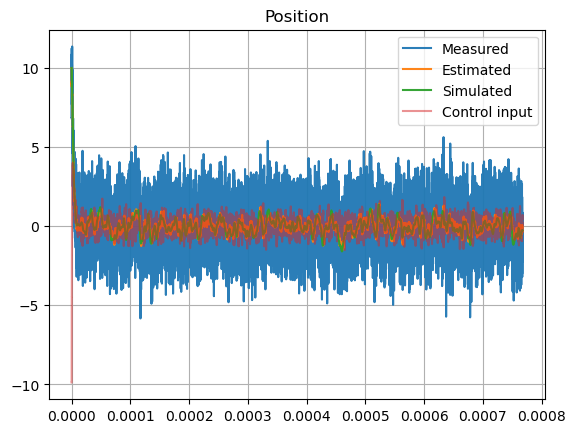

In [18]:
plt.close("all")
fig1 = plt.Figure()
plt.title("Position")
plt.plot(t[1:], measured_states[1:], alpha = 0.95)
plt.plot(t[1:], estimated_states[1:, 2], alpha = 0.95)
plt.plot(t[1:], new_states[1:, 2],alpha = 0.95)
C = max(controls)/4
controls = [x/C for x in controls]
plt.plot(t[1:], controls[1:], alpha = 0.5)
plt.grid()
plt.legend(["Measured", "Estimated", "Simulated", "Control input"])
plt.show()

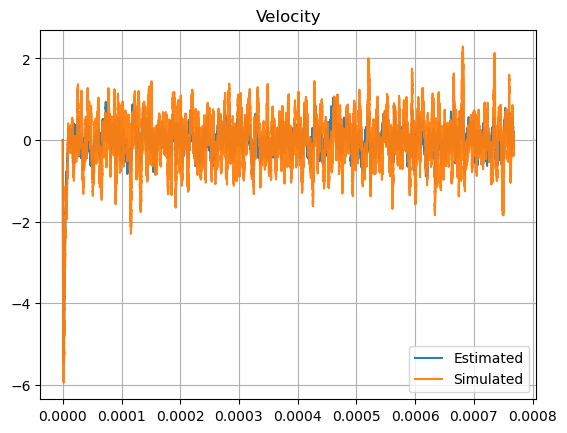

In [19]:
plt.close("all")
fig1 = plt.Figure()
plt.title("Velocity")
plt.plot(t[1:], estimated_states[1:, 3], alpha = 0.95)
plt.plot(t[1:], new_states[1:, 3],alpha = 0.95)
plt.grid()
plt.legend(["Estimated", "Simulated"])
plt.show()

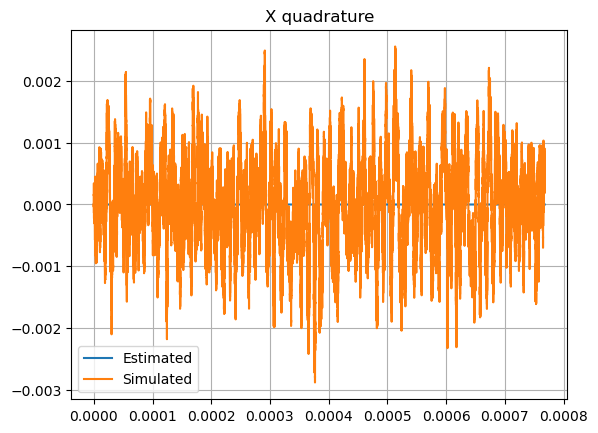

In [20]:
plt.figure()
#fig2 = plt.Figure()
plt.title('X quadrature')
plt.plot(t[1:], estimated_states[1:,0])
plt.plot(t[1:], new_states[1:,0])
plt.grid()
plt.legend(['Estimated','Simulated'])
plt.show()

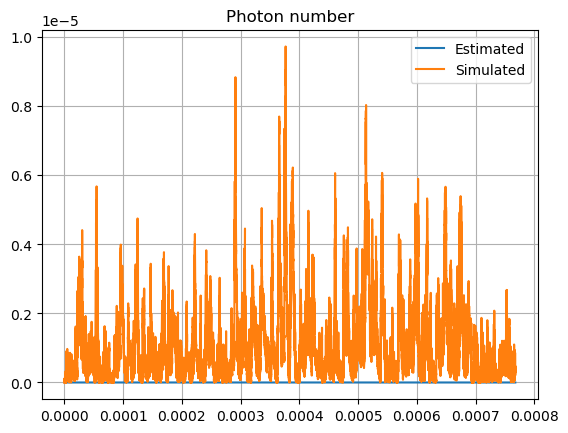

In [21]:

# In[63]:
fig2 = plt.Figure()
plt.figure()
plt.title("Photon number")
plt.plot(
    t[1:], np.power(estimated_states[1:, 0], 2) + np.power(estimated_states[1:, 1], 2)
)
plt.plot(t[1:], np.power(new_states[1:, 0], 2) + np.power(new_states[1:, 1], 2))
plt.grid()
plt.legend(["Estimated", "Simulated"])
plt.show()


In [22]:
kalman.error_covariance_apriori[-1]

matrix([[1.00615180e-06, 1.39631129e-21, 0.00000000e+00, 0.00000000e+00],
        [1.55274704e-21, 1.00615180e-06, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 5.43588618e-02, 7.00694946e-02],
        [0.00000000e+00, 0.00000000e+00, 7.00694946e-02, 2.35000395e-01]])

In [23]:
df = pd.DataFrame()
df['z'] = estimated_states[400:,2][::1000]
df['p'] = estimated_states[400:,3][::1000]

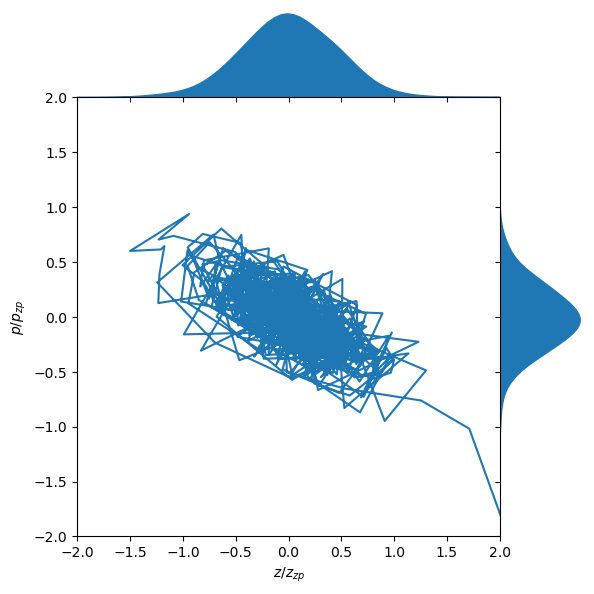

In [24]:
g = sns.JointGrid(data=df, x="z", y="p", space=0, xlim = (-2,2), ylim = (-2,2))
g.plot_joint(sns.lineplot, sort = False,)#clip=((2200, 6800), (10, 25)),
             #thresh=0, levels=100, cmap="rocket")
g.plot_marginals(sns.kdeplot, alpha=1, fill=True)
g.set_axis_labels(r'$z/z_{zp}$',r'$p/p_{zp}$')
